<a href="https://colab.research.google.com/github/XuweiyiChen/Pedestrian_vehicles/blob/jenny/starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% [code]
!pip install -U tensorflow_datasets
!apt install -y fonts-nanum fonts-nanum-coding

import sys
import os
import math

import numpy as np
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

import pathlib

     |████████████████████████████████| 3.7MB 5.9MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.7 MB of archives.
After this operation, 34.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-coding all 2.5-1 [1,083 kB]
Fetched 10.7 MB in 3s (3,435 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 1

In [2]:
TAKE = 10
BATCH = 32
EPOCH = 10
REPEATS = 5

STRING_CODEC = 'UTF-8'

IMG_HEIGHT = 224
IMG_WIDTH = 224
TEXT_LEN = 64
TOKEN_LEN = 16
LATENT = 256

FOLDER_BASE = '/kaggle/input/'
FOLDER = FOLDER_BASE+'naver-posts/'
FOLDER_IMG = FOLDER + 'img/'
FOLDER_SUMMARY = FOLDER + 'summary/'
FOLDER_TEXT = FOLDER + 'text/'
VOCAB_PATH = FOLDER + 'vocab'

FOLDER_W2T2V = FOLDER_BASE+'word2token2vec/'

TOKEN_SOS = '<SOS>'
TOKEN_EOS = '<EOS>'

# Any results you write to the current directory are saved as output.
print(tf.version.VERSION)

2.4.1


In [3]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 5s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['roses', 'sunflowers', 'dandelion', 'tulips', 'daisy'],
      dtype='<U10')

In [6]:
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


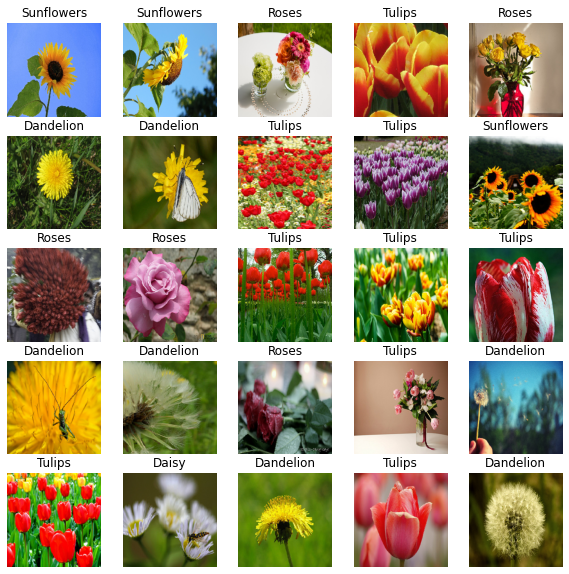

In [7]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [8]:
def gen():
    yield from train_data_gen

ds = tf.data.Dataset.from_generator(gen, 
                                   (tf.float32, tf.int64),
                                   (tf.TensorShape([None, IMG_HEIGHT, IMG_WIDTH, 3]), tf.TensorShape([None, len(CLASS_NAMES)])))

for x in ds.take(1):
    print(x)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6509804 , 0.44705886, 0.15294118],
         [0.6039216 , 0.43137258, 0.14509805],
         [0.54901963, 0.3921569 , 0.12156864],
         ...,
         [0.70980394, 0.49803925, 0.10588236],
         [0.70980394, 0.49803925, 0.10588236],
         [0.7058824 , 0.49411768, 0.10980393]],

        [[0.67058825, 0.45098042, 0.16078432],
         [0.6392157 , 0.4431373 , 0.15686275],
         [0.6313726 , 0.44705886, 0.17254902],
         ...,
         [0.7137255 , 0.5019608 , 0.10980393],
         [0.7137255 , 0.5019608 , 0.10980393],
         [0.7137255 , 0.5019608 , 0.10980393]],

        [[0.67058825, 0.43529415, 0.16078432],
         [0.63529414, 0.4156863 , 0.12156864],
         [0.6392157 , 0.427451  , 0.14509805],
         ...,
         [0.7137255 , 0.5019608 , 0.10980393],
         [0.7137255 , 0.5019608 , 0.10980393],
         [0.70980394, 0.49803925, 0.10588236]],

        ...,

        [[0.69411767, 0.4901961 

In [9]:
def model_img_encoder(img_input, latent_unit):
    def res_block(input_layer, filters, downsample=False, name=None):
        with tf.name_scope("res_block"):
            out = input_layer

            if downsample:
                out = keras.layers.Conv2D(filters * 4, (3, 3), strides=(2, 2), name=name+"_downsample")(out)
                input_layer = out
                
            out = keras.layers.Conv2D(filters, (1, 1), padding='same')(out)
            out = keras.layers.BatchNormalization()(out)
            out = keras.layers.LeakyReLU(0.2)(out)

            out = keras.layers.Conv2D(filters, (3, 3), padding='same')(out)
            out = keras.layers.BatchNormalization()(out)
            out = keras.layers.LeakyReLU(0.2)(out)

            out = keras.layers.Conv2D(filters * 4, (1, 1), padding='same')(out)  
            out = keras.layers.BatchNormalization()(out)  

            out = out + input_layer
            out = keras.layers.LeakyReLU(0.2, name=name+"_out")(out)

            return out
    
    img = img_input
    
    img = keras.layers.Conv2D(64, (7, 7), strides=(2, 2))(img)
    img = keras.layers.BatchNormalization()(img)
    img = keras.layers.LeakyReLU(0.2)(img)
    img = keras.layers.MaxPool2D((3, 3), strides=(2, 2), name="pre")(img)
    
    img = res_block(img, 64, True, name="stg1-d")
    for i in range(2):
        img = res_block(img, 64, name="stg1-"+str(i))
    
    img = res_block(img, 128, True, name="stg2-d")
    for i in range(3):
        img = res_block(img, 128, name="stg2-"+str(i))

    img = res_block(img, 256, True, name="stg3-d")
    for i in range(22):
        img = res_block(img, 256, name="stg3-"+str(i))
    
    img = res_block(img, 512, True, name="stg4-d")
    for i in range(2):
        img = res_block(img, 512, name="stg4-"+str(i))
    
    img = keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(img)
    img = keras.layers.Flatten()(img)
    img = keras.layers.Dense(latent_unit)(img)
    return keras.Model(inputs=[img_input], outputs=[img], name='image_latent')

In [10]:
input_image = keras.Input((IMG_HEIGHT, IMG_WIDTH, 3), name='input_img')

model_infer = model_img_encoder(input_image, LATENT)
model_infer.summary()

Model: "image_latent"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 64) 9472        input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 109, 109, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 109, 109, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
img_latent = model_infer(input_image)

classify = keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(img_latent)

model_train = keras.Model(inputs=[input_image], outputs=[classify])
model_train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_train.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
image_latent (Functional)    (None, 256)               66018944  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 66,020,229
Trainable params: 65,922,565
Non-trainable params: 97,664
_________________________________________________________________


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('model_image2vec_train.h5', save_best_only=True)

VALID_TAKE = 3
ds_validation = ds.take(VALID_TAKE).cache()
    
model_train.fit(ds.skip(VALID_TAKE).prefetch(TAKE*2).take(TAKE),
          validation_data=ds_validation,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
      7/Unknown - 139s 19s/step - loss: 3.2682 - acc: 0.1786